# Neural Nets for MNIST dataset.
Hope this is better than the Logisic regression..

In [32]:
# import statements

import torch
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [33]:
train_data = MNIST('./data', train=True,transform= ToTensor(), download=True)
val_data = MNIST('./data', train=False,transform= ToTensor(), download=False)

In [34]:
((train_data[0][0].shape))

torch.Size([1, 28, 28])

In [35]:
def split_indices(n, val_pct):
    val = int(n*val_pct)
    indices = np.random.permutation(n)
    return indices[:val], indices[val:]

train_indices, val_indices = split_indices(len(train_data), 0.2)

In [36]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

In [37]:
import torch.nn as nn 
from torch.nn.functional import relu
from torch.nn.functional import cross_entropy

In [38]:
class MNIST_DL(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, X):
        X = X.view(X.size(0), -1)
        output = self.l1(X)
        output = relu(output)
        output = self.l2(output)
        return output

In [39]:
input_size = 28*28
hidden_size = 32
output_size = 10

model = MNIST_DL(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

In [40]:
for l in model.parameters():
    print(l.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [41]:
for images, labels in train_dataloader:
    output = model(images)
    loss = cross_entropy(output, labels)
    print(f'Loss: {loss.item()}')
    break

Loss: 2.3098948001861572


In [42]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [43]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking = True)

In [44]:
for images, labels in train_dataloader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [45]:
class DeviceDataLoader:
    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
    
    def __iter__(self):
        for data in self.data_loader:
            yield to_device(data, self.device)
    
    def __len__(self):
        return len(self.data_loader)

In [46]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

In [47]:
def evaluate(model, criterion, val_dataloader, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, criterion, X, y, metric=metric) for X, y in val_dataloader]

        losses, nums, metrics = zip(*results)

        total = np.sum(nums)

        avg_loss = np.sum(np.multiply(losses, nums)) / total

        avg_metric = None

        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums))/ total

    return avg_loss, total, avg_metric

In [48]:
def loss_batch(model, criterion, X, y, optimiser=None, metric = None):
    with torch.enable_grad():

        predictions = model(X)
        loss = criterion(predictions, y)

    if optimiser is not None:
        
        loss.backward()

        optimiser.step()

        optimiser.zero_grad()

    metric_result = None

    if metric is not None:
        metric_result = metric(predictions, y)
    
    return loss.item(), len(X), metric_result

In [49]:
def fit(epochs, learning_rate, model, criterion, train_dataloader, val_dataloader, metric=None, optimiser=None):
    losses, metrics = [], []
    
    if optimiser is None:
        optimiser = torch.optim.SGD
    
    optimiser = optimiser(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        for X, y in train_dataloader:
            loss_batch(model, criterion, X, y,optimiser=optimiser)
    
        result = evaluate(model, criterion, val_dataloader, metric)
        val_loss, total, val_metric = result

        losses.append(val_loss)
        metrics.append(val_metric)

        if metric is None:
            print(f'Epoch [{epoch+1} / {epochs}], Loss {val_loss}')
        else:
            print(f"Epoch [{epoch+1}/ {epochs}], Loss = {val_loss}, {metric.__name__}: {val_metric}")
        
    return losses, metrics

In [50]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [51]:
to_device(model, device)

MNIST_DL(
  (l1): Linear(in_features=784, out_features=32, bias=True)
  (l2): Linear(in_features=32, out_features=10, bias=True)
)

In [52]:
val_loss, total, val_acc = evaluate(model, cross_entropy, val_dataloader, metric=accuracy)

print(f'Loss = {val_loss}, accuracy = {val_acc}')

Loss = 2.308432385325432, accuracy = 0.1175


In [53]:
losses1, metrics1 = fit(10, 0.5, model, cross_entropy, train_dataloader, val_dataloader, metric=accuracy)

Epoch [1/ 10], Loss = 0.37686348014200727, accuracy: 0.8851041666666667
Epoch [2/ 10], Loss = 0.2923576731390009, accuracy: 0.91225
Epoch [3/ 10], Loss = 0.25716139141780636, accuracy: 0.9236666666666666
Epoch [4/ 10], Loss = 0.22632283326238395, accuracy: 0.9346458333333333
Epoch [5/ 10], Loss = 0.22741580325334024, accuracy: 0.9332291666666667
Epoch [6/ 10], Loss = 0.20435497935395688, accuracy: 0.9411041666666666
Epoch [7/ 10], Loss = 0.23080966561877478, accuracy: 0.9342291666666667
Epoch [8/ 10], Loss = 0.20960368951006483, accuracy: 0.9394583333333333
Epoch [9/ 10], Loss = 0.1968529758004782, accuracy: 0.9436041666666667
Epoch [10/ 10], Loss = 0.19582254014288386, accuracy: 0.9450416666666667


In [59]:
losses2, metrics2 = fit(10, 0.5, model, cross_entropy, train_dataloader, val_dataloader, metric=accuracy)

Epoch [1/ 10], Loss = 0.19874989652695754, accuracy: 0.9456458333333333
Epoch [2/ 10], Loss = 0.21520815400484328, accuracy: 0.9430416666666667
Epoch [3/ 10], Loss = 0.2092663196963258, accuracy: 0.9454375
Epoch [4/ 10], Loss = 0.20809024044234928, accuracy: 0.9459791666666667
Epoch [5/ 10], Loss = 0.20635169667269412, accuracy: 0.9466458333333333
Epoch [6/ 10], Loss = 0.21041016456050177, accuracy: 0.9467916666666667
Epoch [7/ 10], Loss = 0.2189081856709284, accuracy: 0.9449791666666667
Epoch [8/ 10], Loss = 0.21875055638568786, accuracy: 0.9455208333333334
Epoch [9/ 10], Loss = 0.21803965274399767, accuracy: 0.9466041666666667
Epoch [10/ 10], Loss = 0.21674029535303513, accuracy: 0.9473958333333333


Text(0.5, 1.0, 'Accuracy vs No. of epochs')

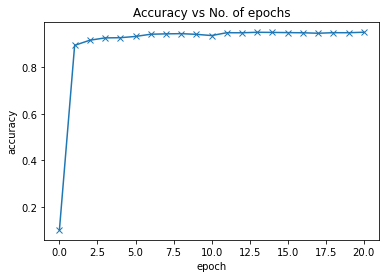

In [24]:
import matplotlib.pyplot as plt
accuracies = [val_acc] + metrics1 + metrics2
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

In [28]:
torch.save(model.state_dict(), './model.txt')

In [29]:
model_new = torch.load('./model.txt')